# Creating a scatter plot between ice fraction and nutrients to understand if there is a relationship between them two, this way I can select the time periods that are lower and higher, and we can compare with maps of abundance, biomass and size abundance slope 

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

## Seasonality and interannual variability in SPECTRA

### Ice Fraction 

In [4]:
ice_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds= xr.open_mfdataset(ice_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [5]:
%%time
ice_ds_inter = np.empty([63,12,180,360])
ice_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    ice_ds_inter[i,:,:,:] = ds.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

CPU times: user 465 ms, sys: 234 ms, total: 700 ms
Wall time: 2.67 s


In [6]:
ice_ao = ice_ds_inter[:,:,149:180,:]
ice_ao_anom = ice_ao-np.nanmean(ice_ao,axis=0)

## NO$_3$

In [7]:
NO3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_NO3*.nc', recursive=True))
ds= xr.open_mfdataset(NO3_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [8]:
%%time
NO3_ds_inter = np.empty([63,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    NO3_ds_inter[i,:,:,:] = ds.NO3[x[i]:x[i]+12,0,:,:]

CPU times: user 526 ms, sys: 212 ms, total: 738 ms
Wall time: 27.4 s


In [9]:
NO3_ao = NO3_ds_inter[:,:,149:180,:] # Selecting the Arctic Ocean region

## Checking how nutrient concentrations and ice fraction are correlated 

Text(0.5, 1.0, 'Summer')

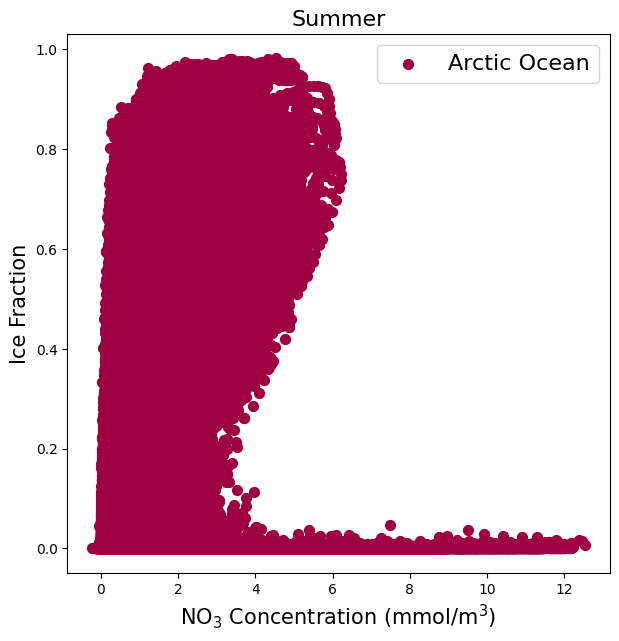

In [10]:
cmap1=matplotlib.cm.get_cmap('Spectral', 11)

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('NO$_3$ Concentration (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel('Ice Fraction', fontsize = 15)

ax.scatter(np.nanmean(NO3_ao[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ao[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(0), s = 50,label='Arctic Ocean')
transform = ax.transAxes
ax.legend(loc='best', fontsize=16)
ax.set_title('Summer', fontsize =16)

## Separate by Arctic Regions

In [14]:
# NO3
no3_ao = NO3_ds_inter[:,:,170:180,:]
no3_cs = NO3_ds_inter[:,:,149:170,0:25]
no3_bs = NO3_ds_inter[:,:,149:170,25:55]
no3_ca = NO3_ds_inter[:,:,149:170,55:110]
no3_bb = NO3_ds_inter[:,:,149:170,110:135]
no3_ess = NO3_ds_inter[:,:,149:170,325:360]
no3_ls = NO3_ds_inter[:,:,149:170,270:325]
no3_ns = NO3_ds_inter[:,:,149:170,155:205]
no3_bts =NO3_ds_inter[:,:,149:170,205:233]
no3_ks = NO3_ds_inter[:,:,149:170,233:270]

# Ice Fraction 
ice_ao = ice_ds_inter[:,:,170:180,:]
ice_cs = ice_ds_inter[:,:,149:170,0:25]
ice_bs = ice_ds_inter[:,:,149:170,25:55]
ice_ca = ice_ds_inter[:,:,149:170,55:110]
ice_bb = ice_ds_inter[:,:,149:170,110:135]
ice_ess = ice_ds_inter[:,:,149:170,325:360]
ice_ls = ice_ds_inter[:,:,149:170,270:325]
ice_ns = ice_ds_inter[:,:,149:170,155:205]
ice_bts =ice_ds_inter[:,:,149:170,205:233]
ice_ks = ice_ds_inter[:,:,149:170,233:270]

In [15]:
no3_ao.shape

(63, 12, 10, 360)

Text(0.5, 1.0, 'Spring')

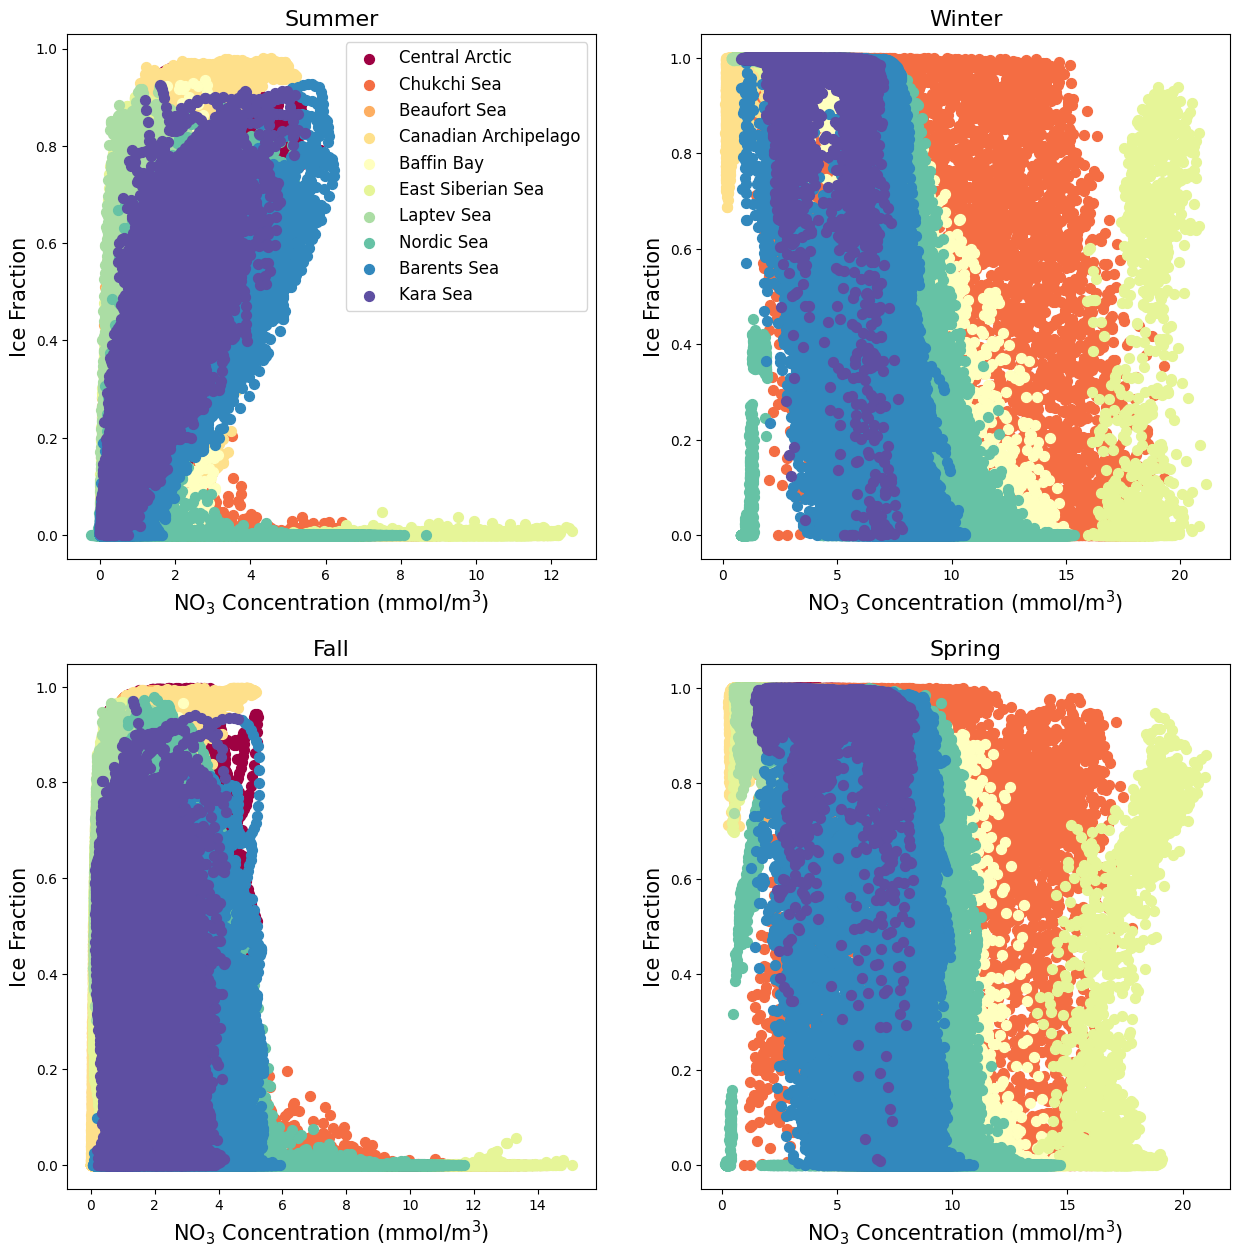

In [28]:
cmap1=matplotlib.cm.get_cmap('Spectral', 11)

fig = plt.figure(figsize = (15,15))

## Summer
ax = fig.add_subplot(2,2,1) 
ax.set_xlabel('NO$_3$ Concentration (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel('Ice Fraction', fontsize = 15)

ax.scatter(np.nanmean(no3_ao[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ao[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(0), s = 50,label='Central Arctic')
ax.scatter(np.nanmean(no3_cs[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_cs[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(2), s = 50,label='Chukchi Sea')
ax.scatter(np.nanmean(no3_bs[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bs[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(3), s = 50,label='Beaufort Sea')
ax.scatter(np.nanmean(no3_ca[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ca[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(4), s = 50,label='Canadian Archipelago')
ax.scatter(np.nanmean(no3_bb[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bb[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(5), s = 50,label='Baffin Bay')
ax.scatter(np.nanmean(no3_ess[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ess[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(6), s = 50,label='East Siberian Sea')
ax.scatter(np.nanmean(no3_ls[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ls[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(7), s = 50,label='Laptev Sea')
ax.scatter(np.nanmean(no3_ns[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ns[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(8), s = 50,label='Nordic Sea')
ax.scatter(np.nanmean(no3_bts[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bts[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(9), s = 50,label='Barents Sea')
ax.scatter(np.nanmean(no3_ks[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ks[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(10), s = 50,label='Kara Sea')
transform = ax.transAxes
ax.legend(loc='best', fontsize=12)
ax.set_title('Summer', fontsize =16)

## Winter
ax = fig.add_subplot(2,2,2) 
ax.set_xlabel('NO$_3$ Concentration (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel('Ice Fraction', fontsize = 15)

ax.scatter(np.nanmean(no3_ao[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ao[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(0), s = 50,label='Central Arctic')
ax.scatter(np.nanmean(no3_cs[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_cs[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(2), s = 50,label='Chukchi Sea')
ax.scatter(np.nanmean(no3_bs[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_bs[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(3), s = 50,label='Beaufort Sea')
ax.scatter(np.nanmean(no3_ca[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ca[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(4), s = 50,label='Canadian Archipelago')
ax.scatter(np.nanmean(no3_bb[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_bb[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(5), s = 50,label='Baffin Bay')
ax.scatter(np.nanmean(no3_ess[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ess[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(6), s = 50,label='East Siberian Sea')
ax.scatter(np.nanmean(no3_ls[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ls[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(7), s = 50,label='Laptev Sea')
ax.scatter(np.nanmean(no3_ns[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ns[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(8), s = 50,label='Nordic Sea')
ax.scatter(np.nanmean(no3_bts[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_bts[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(9), s = 50,label='Barents Sea')
ax.scatter(np.nanmean(no3_ks[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ks[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(10), s = 50,label='Kara Sea')
transform = ax.transAxes
#ax.legend(loc='best', fontsize=12)
ax.set_title('Winter', fontsize =16)

## Fall
ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('NO$_3$ Concentration (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel('Ice Fraction', fontsize = 15)

ax.scatter(np.nanmean(no3_ao[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ao[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(0), s = 50,label='Central Arctic')
ax.scatter(np.nanmean(no3_cs[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_cs[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(2), s = 50,label='Chukchi Sea')
ax.scatter(np.nanmean(no3_bs[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bs[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(3), s = 50,label='Beaufort Sea')
ax.scatter(np.nanmean(no3_ca[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ca[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(4), s = 50,label='Canadian Archipelago')
ax.scatter(np.nanmean(no3_bb[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bb[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(5), s = 50,label='Baffin Bay')
ax.scatter(np.nanmean(no3_ess[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ess[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(6), s = 50,label='East Siberian Sea')
ax.scatter(np.nanmean(no3_ls[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ls[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(7), s = 50,label='Laptev Sea')
ax.scatter(np.nanmean(no3_ns[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ns[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(8), s = 50,label='Nordic Sea')
ax.scatter(np.nanmean(no3_bts[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bts[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(9), s = 50,label='Barents Sea')
ax.scatter(np.nanmean(no3_ks[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ks[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(10), s = 50,label='Kara Sea')
transform = ax.transAxes
#ax.legend(loc='best', fontsize=12)
ax.set_title('Fall', fontsize =16)

## Spring
ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('NO$_3$ Concentration (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel('Ice Fraction', fontsize = 15)

ax.scatter(np.nanmean(no3_ao[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ao[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(0), s = 50,label='Central Arctic')
ax.scatter(np.nanmean(no3_cs[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_cs[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(2), s = 50,label='Chukchi Sea')
ax.scatter(np.nanmean(no3_bs[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bs[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(3), s = 50,label='Beaufort Sea')
ax.scatter(np.nanmean(no3_ca[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ca[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(4), s = 50,label='Canadian Archipelago')
ax.scatter(np.nanmean(no3_bb[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bb[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(5), s = 50,label='Baffin Bay')
ax.scatter(np.nanmean(no3_ess[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ess[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(6), s = 50,label='East Siberian Sea')
ax.scatter(np.nanmean(no3_ls[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ls[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(7), s = 50,label='Laptev Sea')
ax.scatter(np.nanmean(no3_ns[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ns[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(8), s = 50,label='Nordic Sea')
ax.scatter(np.nanmean(no3_bts[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bts[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(9), s = 50,label='Barents Sea')
ax.scatter(np.nanmean(no3_ks[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ks[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(10), s = 50,label='Kara Sea')
transform = ax.transAxes
#ax.legend(loc='best', fontsize=12)
ax.set_title('Spring', fontsize =16)



## Anomaly: NO3 subtracting every year and month by a montly average of NO3 of the full 62 year cycle 

In [30]:
NO3_ao_anom = NO3_ao-np.nanmean(NO3_ao,axis=0) 

Text(0.5, 1.0, 'Summer')

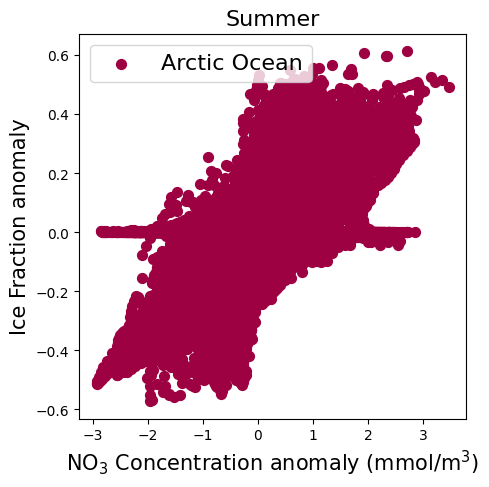

In [31]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
cmap1=matplotlib.cm.get_cmap('Spectral', 11)

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('NO$_3$ Concentration anomaly (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel('Ice Fraction anomaly', fontsize = 15)

ax.scatter(np.nanmean(NO3_ao_anom[:,5:8,:,:],axis=1).flatten(),
           np.nanmean(ice_ao_anom[:,5:8,:,:],axis=1).flatten(),
           color = cmap1(0), s = 50,label='Arctic Ocean')
transform = ax.transAxes
ax.legend(loc='best', fontsize=16)
ax.set_title('Summer', fontsize =16)

In [35]:
# NO3
no3_ao = NO3_ds_inter[:,:,170:180,:] - np.nanmean(NO3_ds_inter[:,:,170:180,:],axis=0) 
no3_cs = NO3_ds_inter[:,:,149:170,0:25] - np.nanmean(NO3_ds_inter[:,:,149:170,0:25],axis=0)
no3_bs = NO3_ds_inter[:,:,149:170,25:55]- np.nanmean(NO3_ds_inter[:,:,149:170,25:55],axis=0)
no3_ca = NO3_ds_inter[:,:,149:170,55:110]- np.nanmean(NO3_ds_inter[:,:,149:170,55:110],axis=0)
no3_bb = NO3_ds_inter[:,:,149:170,110:135]- np.nanmean(NO3_ds_inter[:,:,149:170,110:135],axis=0)
no3_ess = NO3_ds_inter[:,:,149:170,325:360]- np.nanmean(NO3_ds_inter[:,:,149:170,325:360],axis=0)
no3_ls = NO3_ds_inter[:,:,149:170,270:325]- np.nanmean(NO3_ds_inter[:,:,149:170,270:325],axis=0)
no3_ns = NO3_ds_inter[:,:,149:170,155:205]- np.nanmean(NO3_ds_inter[:,:,149:170,155:205],axis=0)
no3_bts =NO3_ds_inter[:,:,149:170,205:233]- np.nanmean(NO3_ds_inter[:,:,149:170,205:233],axis=0)
no3_ks = NO3_ds_inter[:,:,149:170,233:270]- np.nanmean(NO3_ds_inter[:,:,149:170,233:270],axis=0)

# Ice Fraction 
ice_ao = ice_ds_inter[:,:,170:180,:]- np.nanmean(ice_ds_inter[:,:,170:180,:],axis=0)
ice_cs = ice_ds_inter[:,:,149:170,0:25]- np.nanmean(ice_ds_inter[:,:,149:170,0:25],axis=0)
ice_bs = ice_ds_inter[:,:,149:170,25:55]- np.nanmean(ice_ds_inter[:,:,149:170,25:55],axis=0)
ice_ca = ice_ds_inter[:,:,149:170,55:110]- np.nanmean(ice_ds_inter[:,:,149:170,55:110],axis=0)
ice_bb = ice_ds_inter[:,:,149:170,110:135]- np.nanmean(ice_ds_inter[:,:,149:170,110:135],axis=0)
ice_ess = ice_ds_inter[:,:,149:170,325:360]- np.nanmean(ice_ds_inter[:,:,149:170,325:360],axis=0)
ice_ls = ice_ds_inter[:,:,149:170,270:325]- np.nanmean(ice_ds_inter[:,:,149:170,270:325],axis=0)
ice_ns = ice_ds_inter[:,:,149:170,155:205]- np.nanmean(ice_ds_inter[:,:,149:170,155:205],axis=0)
ice_bts =ice_ds_inter[:,:,149:170,205:233]- np.nanmean(ice_ds_inter[:,:,149:170,205:233],axis=0)
ice_ks = ice_ds_inter[:,:,149:170,233:270]- np.nanmean(ice_ds_inter[:,:,149:170,233:270],axis=0)

Text(0.5, 1.0, 'Spring')

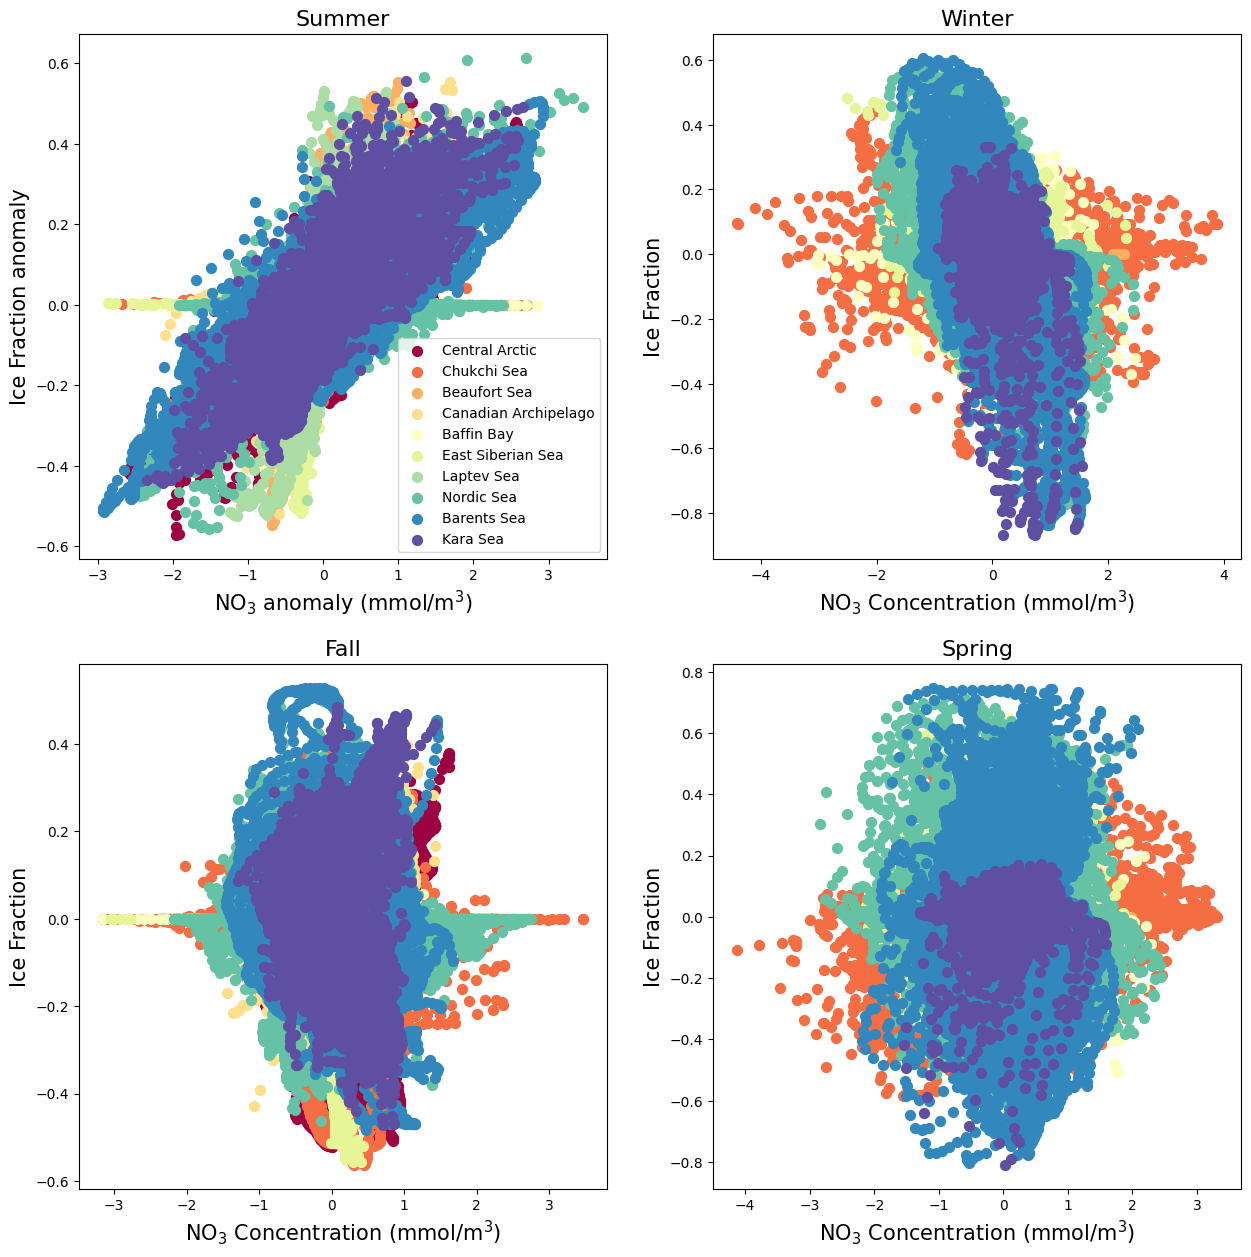

In [37]:
cmap1=matplotlib.cm.get_cmap('Spectral', 11)

fig = plt.figure(figsize = (15,15))

## Summer
ax = fig.add_subplot(2,2,1) 
ax.set_xlabel('NO$_3$ anomaly (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel('Ice Fraction anomaly', fontsize = 15)

ax.scatter(np.nanmean(no3_ao[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ao[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(0), s = 50,label='Central Arctic')
ax.scatter(np.nanmean(no3_cs[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_cs[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(2), s = 50,label='Chukchi Sea')
ax.scatter(np.nanmean(no3_bs[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bs[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(3), s = 50,label='Beaufort Sea')
ax.scatter(np.nanmean(no3_ca[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ca[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(4), s = 50,label='Canadian Archipelago')
ax.scatter(np.nanmean(no3_bb[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bb[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(5), s = 50,label='Baffin Bay')
ax.scatter(np.nanmean(no3_ess[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ess[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(6), s = 50,label='East Siberian Sea')
ax.scatter(np.nanmean(no3_ls[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ls[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(7), s = 50,label='Laptev Sea')
ax.scatter(np.nanmean(no3_ns[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ns[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(8), s = 50,label='Nordic Sea')
ax.scatter(np.nanmean(no3_bts[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bts[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(9), s = 50,label='Barents Sea')
ax.scatter(np.nanmean(no3_ks[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ks[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(10), s = 50,label='Kara Sea')
transform = ax.transAxes
ax.legend(loc='best', fontsize=10)
ax.set_title('Summer', fontsize =16)

## Winter
ax = fig.add_subplot(2,2,2) 
ax.set_xlabel('NO$_3$ Concentration (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel('Ice Fraction', fontsize = 15)

ax.scatter(np.nanmean(no3_ao[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ao[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(0), s = 50,label='Central Arctic')
ax.scatter(np.nanmean(no3_cs[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_cs[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(2), s = 50,label='Chukchi Sea')
ax.scatter(np.nanmean(no3_bs[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_bs[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(3), s = 50,label='Beaufort Sea')
ax.scatter(np.nanmean(no3_ca[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ca[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(4), s = 50,label='Canadian Archipelago')
ax.scatter(np.nanmean(no3_bb[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_bb[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(5), s = 50,label='Baffin Bay')
ax.scatter(np.nanmean(no3_ess[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ess[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(6), s = 50,label='East Siberian Sea')
ax.scatter(np.nanmean(no3_ls[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ls[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(7), s = 50,label='Laptev Sea')
ax.scatter(np.nanmean(no3_ns[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ns[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(8), s = 50,label='Nordic Sea')
ax.scatter(np.nanmean(no3_bts[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_bts[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(9), s = 50,label='Barents Sea')
ax.scatter(np.nanmean(no3_ks[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           np.nanmean(ice_ks[:,list(range(2)) + [-1],:,:],axis=(1)).flatten(),
           color = cmap1(10), s = 50,label='Kara Sea')
transform = ax.transAxes
#ax.legend(loc='best', fontsize=12)
ax.set_title('Winter', fontsize =16)

## Fall
ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('NO$_3$ Concentration (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel('Ice Fraction', fontsize = 15)

ax.scatter(np.nanmean(no3_ao[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ao[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(0), s = 50,label='Central Arctic')
ax.scatter(np.nanmean(no3_cs[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_cs[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(2), s = 50,label='Chukchi Sea')
ax.scatter(np.nanmean(no3_bs[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bs[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(3), s = 50,label='Beaufort Sea')
ax.scatter(np.nanmean(no3_ca[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ca[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(4), s = 50,label='Canadian Archipelago')
ax.scatter(np.nanmean(no3_bb[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bb[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(5), s = 50,label='Baffin Bay')
ax.scatter(np.nanmean(no3_ess[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ess[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(6), s = 50,label='East Siberian Sea')
ax.scatter(np.nanmean(no3_ls[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ls[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(7), s = 50,label='Laptev Sea')
ax.scatter(np.nanmean(no3_ns[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ns[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(8), s = 50,label='Nordic Sea')
ax.scatter(np.nanmean(no3_bts[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bts[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(9), s = 50,label='Barents Sea')
ax.scatter(np.nanmean(no3_ks[:,8:11,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ks[:,8:11,:,:],axis=(1)).flatten(),
           color = cmap1(10), s = 50,label='Kara Sea')
transform = ax.transAxes
#ax.legend(loc='best', fontsize=12)
ax.set_title('Fall', fontsize =16)

## Spring
ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('NO$_3$ Concentration (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel('Ice Fraction', fontsize = 15)

ax.scatter(np.nanmean(no3_ao[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ao[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(0), s = 50,label='Central Arctic')
ax.scatter(np.nanmean(no3_cs[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_cs[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(2), s = 50,label='Chukchi Sea')
ax.scatter(np.nanmean(no3_bs[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bs[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(3), s = 50,label='Beaufort Sea')
ax.scatter(np.nanmean(no3_ca[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ca[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(4), s = 50,label='Canadian Archipelago')
ax.scatter(np.nanmean(no3_bb[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bb[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(5), s = 50,label='Baffin Bay')
ax.scatter(np.nanmean(no3_ess[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ess[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(6), s = 50,label='East Siberian Sea')
ax.scatter(np.nanmean(no3_ls[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ls[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(7), s = 50,label='Laptev Sea')
ax.scatter(np.nanmean(no3_ns[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ns[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(8), s = 50,label='Nordic Sea')
ax.scatter(np.nanmean(no3_bts[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_bts[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(9), s = 50,label='Barents Sea')
ax.scatter(np.nanmean(no3_ks[:,2:5,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ks[:,2:5,:,:],axis=(1)).flatten(),
           color = cmap1(10), s = 50,label='Kara Sea')
transform = ax.transAxes
#ax.legend(loc='best', fontsize=12)
ax.set_title('Spring', fontsize =16)



## Compare between low and high nitrate years ... and low and high ice fraction years?

In [12]:
no3_arctic = np.nanmean(NO3_ds_inter[:,:,149:180,:], axis=(2,3))
no3_arctic_anom = no3_arctic-np.nanmean(no3_arctic,axis=0)
err_ao = np.nanstd(no3_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) < -(err_ao/2))
high_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) > (err_ao/2))

In [14]:
ice_arctic = np.nanmean(ice_ds_inter[:,:,149:180,:], axis=(2,3))
ice_arctic_anom = ice_arctic-np.nanmean(ice_arctic,axis=0)
err_ao = np.nanstd(ice_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) < -(err_ao/2))
high_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) > (err_ao/2))

In [14]:
NO3_ao.shape

(63, 12, 31, 360)

Text(0.5, 1.0, 'Summer')

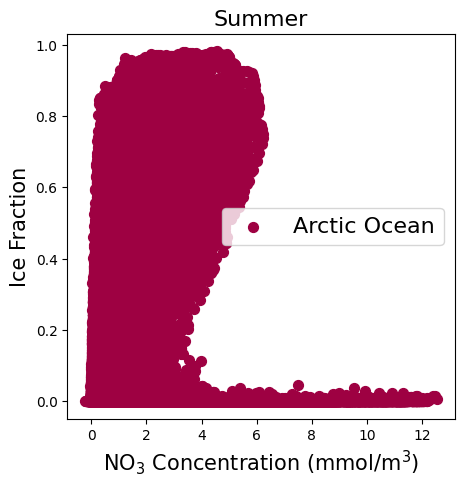

In [19]:
cmap1=matplotlib.cm.get_cmap('Spectral', 11)

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('NO$_3$ Concentration (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel('Ice Fraction', fontsize = 15)

ax.scatter(np.nanmean(NO3_ao[:,5:8,:,:],axis=(1)).flatten(),
           np.nanmean(ice_ao[:,5:8,:,:],axis=(1)).flatten(),
           color = cmap1(0), s = 50,label='Arctic Ocean')
transform = ax.transAxes
ax.legend(loc='best', fontsize=16)
ax.set_title('Summer', fontsize =16)

### Create a dataframe to attempt the sns.joinplot()

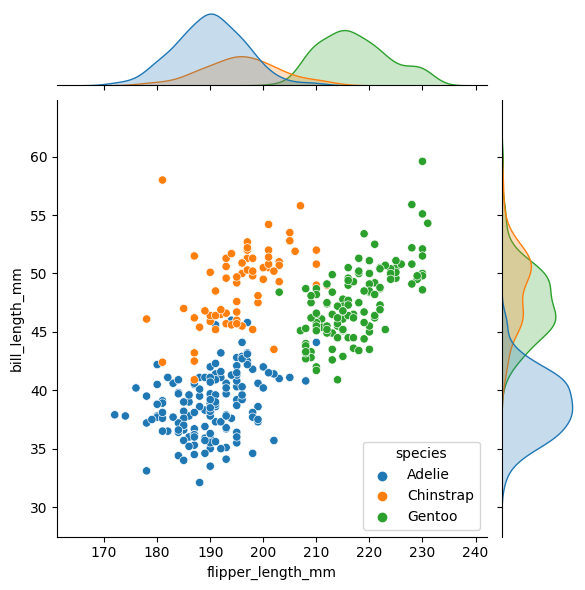

In [24]:
penguins = sns.load_dataset("penguins")
sns.jointplot(data=penguins, x="flipper_length_mm", y="bill_length_mm", hue="species")

## Now import the growth limitation terms for picoplankton gridded 

In [ ]:
path_to_regrid = '/glade/u/home/gabyn/scratch/SPECTRA/growth_lim'
ds_diat3_index= xr.open_mfdataset(f"{path_to_regrid}/regrid_diat3_lim_index.nc",concat_dim='time', combine='nested') 
ds_diat3_value= xr.open_mfdataset(f"{path_to_regrid}/regrid_diat3_lim_value.nc",concat_dim='time', combine='nested') 

In [ ]:
path_to_regrid = '/glade/u/home/gabyn/scratch/SPECTRA/growth_lim'
ds_diat1_index= xr.open_mfdataset(f"{path_to_regrid}/regrid_diat1_lim_index.nc",concat_dim='time', combine='nested') 
ds_diat1_value= xr.open_mfdataset(f"{path_to_regrid}/regrid_diat1_lim_value.nc",concat_dim='time', combine='nested') 

In [15]:
#ds_pp_index.pp_lim_index[:,149:180,:]
summer_diat3_lim = ds_diat3_value.diat3_lim_value[:,5:8,149:180,:]

In [16]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.9994925028835063, 0.9192618223760093, 0.6061361014994233),(0.45066769191336664, 0.7509983339741125, 0.7703857490708702),(0.6825187635707243, 0.810691907283208, 0.6352470180118206)]

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=3)

In [17]:
X=np.array(NO3_ao_anom[:,5:8,:,:].flatten())[~np.isnan((np.array(ice_ao_anom[:,5:8,:,:].flatten())))]
Y=np.array(ice_ao_anom[:,5:8,:,:].flatten())[~np.isnan((np.array(NO3_ao_anom[:,5:8,:,:].flatten())))]

In [20]:
diat3_lims = (summer_diat3_lim.where(summer_diat3_lim < 0.9) + ds_diat3_index.diat3_lim_index[:,5:8,149:180,:].where(summer_diat3_lim < 0.9))

In [21]:
diat3_lims

<xarray.DataArray (time: 63, month: 3, lat: 31, lon: 360)>
dask.array<add, shape=(63, 3, 31, 360), dtype=float64, chunksize=(63, 3, 31, 360)>
Coordinates:
  * time     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 59.5 60.5 61.5 62.5 63.5 ... 85.5 86.5 87.5 88.5 89.5
  * month    (month) object 0062-07-01 00:00:00 ... 0062-09-01 00:00:00

In [22]:
lim_diat3 = np.array(diat3_lims)[~np.isnan((np.array(NO3_ao_anom[:,5:8,:,:])))]

		NC4_inq_var_all: ncid 0x20000 varid 4
		NC4_inq_var_all: ncid 0x20000 varid 4
		NC4_inq_dim: ncid 0x20000 dimid 0
		NC4_inq_dim: ncid 0x20000 dimid 3
		NC4_inq_dim: ncid 0x20000 dimid 2
		NC4_inq_dim: ncid 0x20000 dimid 1
		NC4_inq_dim: ncid 0x20000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x20000 dimid 3
		NC4_inq_dim: ncid 0x20000 dimid 2
		NC4_inq_dim: ncid 0x20000 dimid 1
		NC4_inq_var_all: ncid 0x20000 varid 4
		NC4_inq_var_all: ncid 0x20000 varid 4
		NC4_inq_dim: ncid 0x20000 dimid 0
		NC4_inq_dim: ncid 0x20000 dimid 3
		NC4_inq_dim: ncid 0x20000 dimid 2
		NC4_inq_dim: ncid 0x20000 dimid 1
		NC4_inq_var_all: ncid 0x20000 varid 4
		NC4_inq_var_all: ncid 0x20000 varid 4
		NC4_inq_dim: ncid 0x20000 dimid 0
		NC4_inq_dim: ncid 0x20000 dimid 3
		NC4_inq_dim: ncid 0x20000 dimid 2
		NC4_inq_dim: ncid 0x20000 dimid 1
		NC4_inq_var_all: ncid 0x20000 varid 4
			NC4_get_vars: var->hdr.name diat3_lim_value mem_nc_type 6
		NC4_inq_dim: ncid 0x20000 dimid 0
			nc4

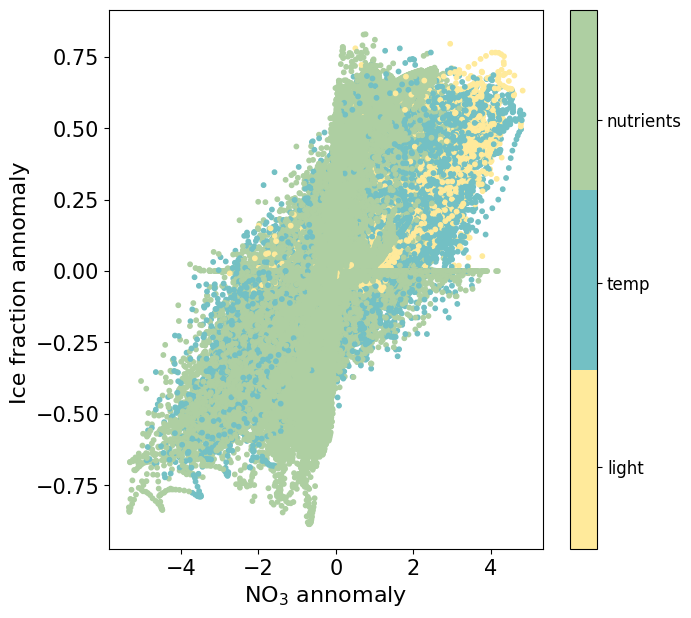

In [23]:
fig = plt.figure(figsize=(7, 7))
z = lim_diat.flatten()
#cbar_ax = fig.add_axes([0.32, 0.03, 0.35, 0.02])
cf = plt.scatter(y=Y,x=X,c=z,s=10, alpha=1,cmap=cm)
plt.yticks(fontsize= 15 );
plt.xticks(fontsize= 15 );
plt.xlabel('NO$_3$ annomaly', fontsize=16)
#cbar = fig.colorbar(cf, cax =cbar_ax, shrink=0.75, spacing='uniform',ticks=[0.5,1.5,2.5,3.5],orientation="horizontal")
#cbar.ax.set_xticklabels(['light','temp', 'nutrients'], fontsize = 18)
plt.ylabel('Ice fraction annomaly ',fontsize = 16)
cbar = plt.colorbar(ticks=[0.4,1.25,2])
cbar.ax.set_yticklabels(['light','temp', 'nutrients'], fontsize = 12)
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/ice_vs_no3_anom_summer_diat3_limitation.png', dpi=600, bbox_inches='tight')

In [29]:
data_diat3 = {'NO3_ao_anom_summer':Y,
       'ice_ao_anom_summer':X,
       'diat3_limitation':lim_diat.flatten()}

In [30]:
# Add labels for limitation terms
nutrient= ['nutrient']
light = ['light']
temperature = ['temp']

In [31]:
result = np.where(lim_diat > 1.8,
                  nutrient,
                 lim_diat)

In [32]:
result_02 = np.where(lim_diat < 0.8,
                  light,
                 result)

In [33]:
result_03 = np.where((lim_diat > 0.8) & (lim_diat < 1.8),
                  temperature,
                 result_02)

In [34]:
data_diat3 = {'NO3_ao_anom_summer':Y,
       'ice_ao_anom_summer':X,
       'diat1_limitation':result_03}
df = pd.DataFrame(data_diat3)

In [35]:
df

,NO3_ao_anom_summer,ice_ao_anom_summer,diat1_limitation
0,-0.000907,-0.255410,nutrient
1,-0.001086,-0.204696,nutrient
2,-0.001342,-0.133646,nutrient
3,-0.001690,-0.071383,nutrient
4,-0.002157,-0.090391,nutrient
...,...,...,...
1241725,-0.096554,-0.062352,nutrient
1241726,-0.096860,-0.062287,nutrient
1241727,-0.097165,-0.062221,nutrient
1241728,-0.097467,-0.062157,nutrient


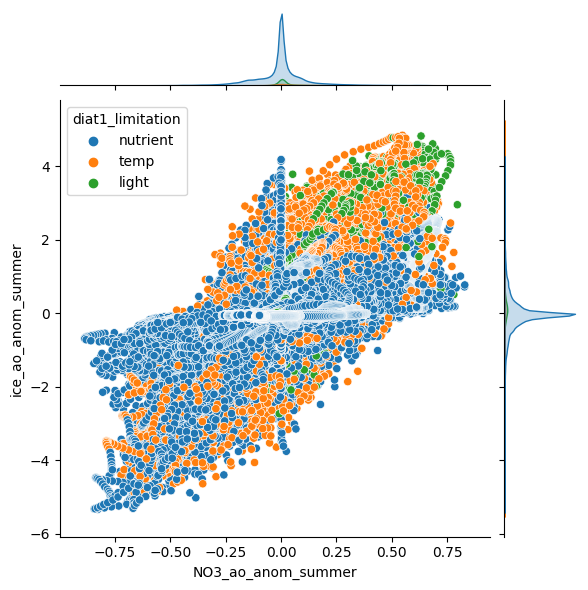

In [92]:
sns.jointplot(data=df, x="NO3_ao_anom_summer", y="ice_ao_anom_summer", hue="diat1_limitation")

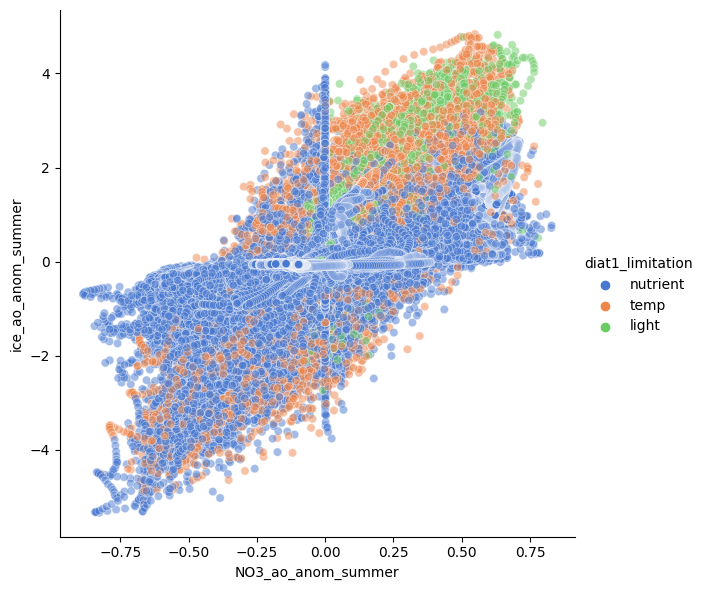

In [93]:
sns.relplot(x="NO3_ao_anom_summer", y="ice_ao_anom_summer", hue="diat1_limitation",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)

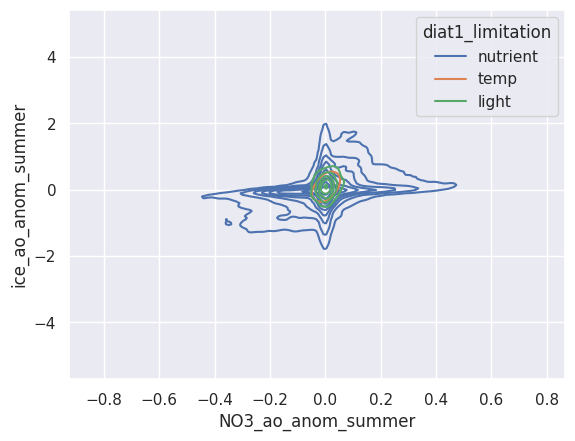

In [33]:
sns.set_theme(style="darkgrid")
# Draw a contour plot to represent each bivariate density
sns.kdeplot(
    data=df,
    x="NO3_ao_anom_summer",
    y="ice_ao_anom_summer",
    hue="diat1_limitation",
    thresh=.1,
)

In [ ]:
data_diat1 = {'NO3_ao_anom_summer':Y,
       'ice_ao_anom_summer':X,
       'diat1_limitation':result_03}
df = pd.DataFrame(data_diat1)

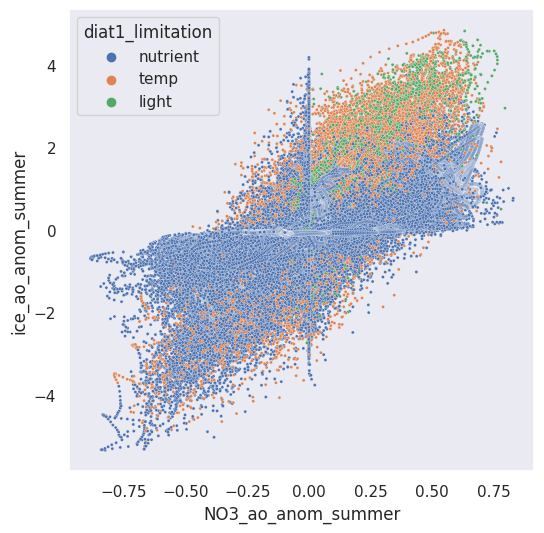

In [36]:

sns.set_theme(style="dark")

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df,
    x="NO3_ao_anom_summer",
    y="ice_ao_anom_summer",
    hue="diat1_limitation", s=5, color=".15")

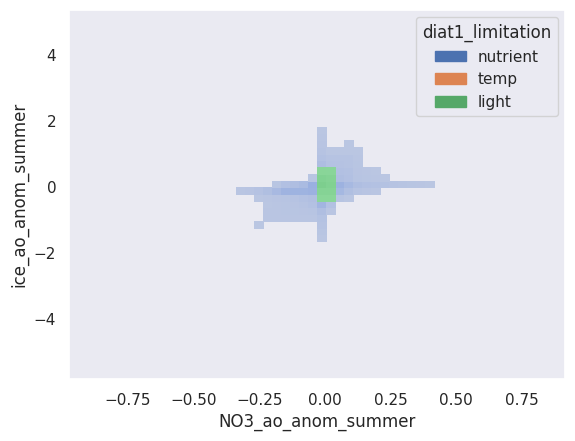

In [38]:
sns.histplot(data=df,
    x="NO3_ao_anom_summer",
    y="ice_ao_anom_summer",
    hue="diat1_limitation", bins=50, pthresh=.1, cmap="mako")

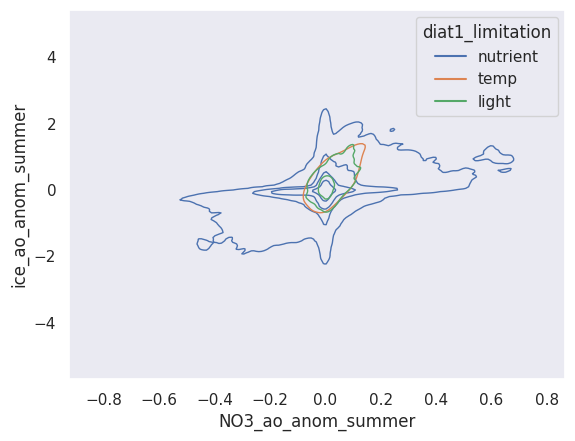

In [37]:
sns.kdeplot(data=df,
    x="NO3_ao_anom_summer",
    y="ice_ao_anom_summer",
    hue="diat1_limitation", levels=5, color="w", linewidths=1)

## Let's attempt to make this more self explanatory, and change the indexes of the values instead of ploting only the actual values themseves! 

In [23]:
# Find the limitaiton values that are less than 0.9
idx_lim_diat1_ao_summer = ds_diat1_index.diat1_lim_index[:,5:8,149:180,:] # index
lim_diat1_ao_summer = ds_diat1_value.diat1_lim_value[:,5:8,149:180,:] # limitation value 
diat1_lims = idx_lim_diat1_ao_summer.where(lim_diat1_ao_summer < 0.9) # only select the indexes that have values less than 0.9

In [ ]:
# Add labels for limitation terms (0-light,1-temp, 2-Nutrient)
nutrient= ['nutrient']
light = ['light']
temperature = ['temp']

rlt1 = np.where(diat1_lims > 1.5,
                  nutrient,
                 diat1_lims)

rlt2 = np.where((diat1_lims > 0.5) & (diat1_lims < 1.5),
                  temperature,
                 rlt1)

rlt3 = np.where(diat1_lims <0.5 ,
                  light,
                 rlt2)

In [ ]:
df_diat1 = {'NO3_ao_anom_summer':np.array(ice_ao_anom[:,5:8,:,:].flatten())[~np.isnan((np.array(NO3_ao_anom[:,5:8,:,:].flatten())))],
           'ice_ao_anom_summer':np.array(NO3_ao_anom[:,5:8,:,:].flatten())[~np.isnan((np.array(ice_ao_anom[:,5:8,:,:].flatten())))],
           'diat1_lim_index':np.array(diat1_lims).flatten()[~np.isnan((np.array(ice_ao_anom[:,5:8,:,:].flatten())))],
           'diat1_lim':rlt3.flatten()[~np.isnan((np.array(ice_ao_anom[:,5:8,:,:].flatten())))]}

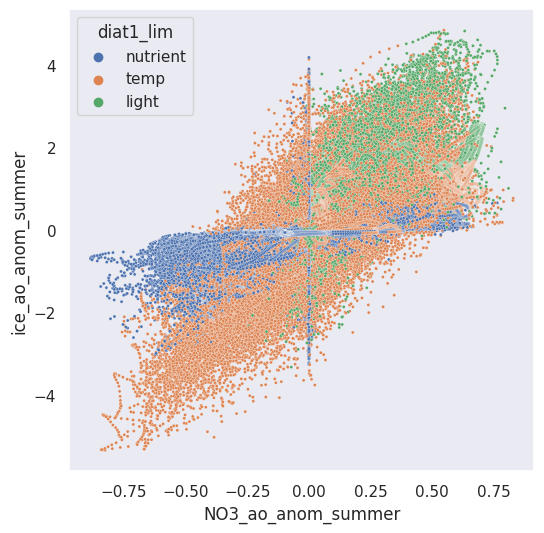

In [107]:
sns.set_theme(style="dark")

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df_diat1,
    x="NO3_ao_anom_summer",
    y="ice_ao_anom_summer",
    hue="diat1_lim", s=5, color=".15")

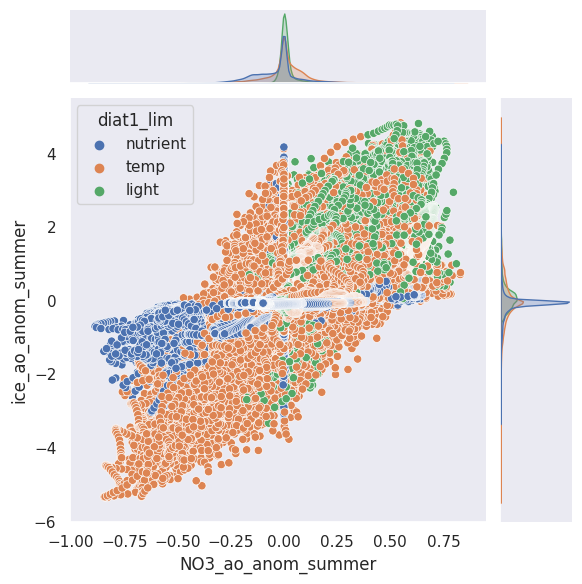

In [108]:
sns.jointplot(data=df_diat1, x="NO3_ao_anom_summer", y="ice_ao_anom_summer", hue="diat1_lim")

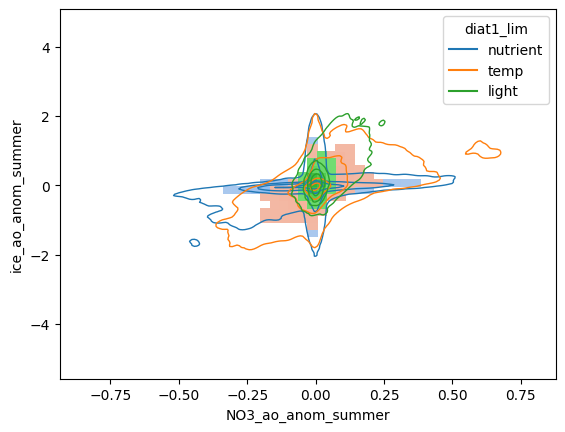

In [27]:
sns.histplot(data=df_diat1,
    x="NO3_ao_anom_summer",
    y="ice_ao_anom_summer",
    hue="diat1_lim", bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(data=df_diat1,
    x="NO3_ao_anom_summer",
    y="ice_ao_anom_summer",
    hue="diat1_lim", levels=5, color="w", linewidths=1)

## Diatom 3

In [28]:
# Find the limitaiton values that are less than 0.9
idx_lim_diat3_ao_summer = ds_diat3_index.diat3_lim_index[:,5:8,149:180,:] # index
lim_diat3_ao_summer = ds_diat3_value.diat3_lim_value[:,5:8,149:180,:] # limitation value 
diat3_lims = idx_lim_diat3_ao_summer.where(lim_diat3_ao_summer < 0.9) # only select the indexes that have values less than 0.9

In [ ]:
# Add labels for limitation terms (0-light,1-temp, 2-Nutrient)
nutrient= ['nutrient']
light = ['light']
temperature = ['temp']

rlt1_3 = np.where(diat3_lims > 1.5,
                  nutrient,
                 diat3_lims)

rlt2_3 = np.where((diat3_lims > 0.5) & (diat3_lims < 1.5),
                  temperature,
                 rlt1_3)

rlt3_3 = np.where(diat3_lims <0.5 ,
                  light,
                 rlt2_3)

In [ ]:
df_diat3 = {'NO3_ao_anom_summer':np.array(ice_ao_anom[:,5:8,:,:].flatten())[~np.isnan((np.array(NO3_ao_anom[:,5:8,:,:].flatten())))],
           'ice_ao_anom_summer':np.array(NO3_ao_anom[:,5:8,:,:].flatten())[~np.isnan((np.array(ice_ao_anom[:,5:8,:,:].flatten())))],
           'diat3_lim_index':np.array(diat3_lims).flatten()[~np.isnan((np.array(ice_ao_anom[:,5:8,:,:].flatten())))],
           'diat3_lim':rlt3_3.flatten()[~np.isnan((np.array(ice_ao_anom[:,5:8,:,:].flatten())))]}

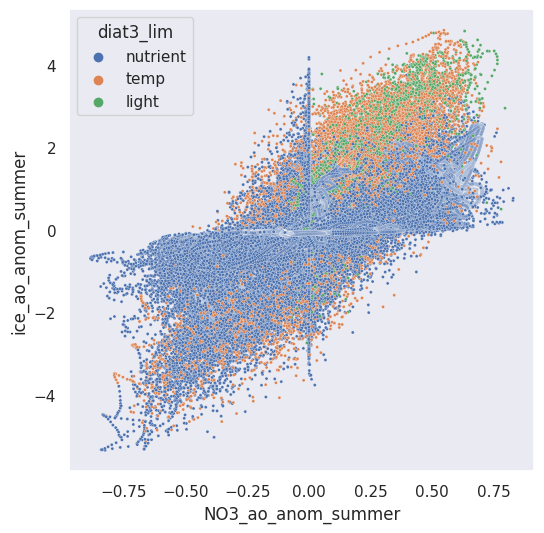

In [31]:
sns.set_theme(style="dark")

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df_diat3,
    x="NO3_ao_anom_summer",
    y="ice_ao_anom_summer",
    hue="diat3_lim", s=5, color=".15")

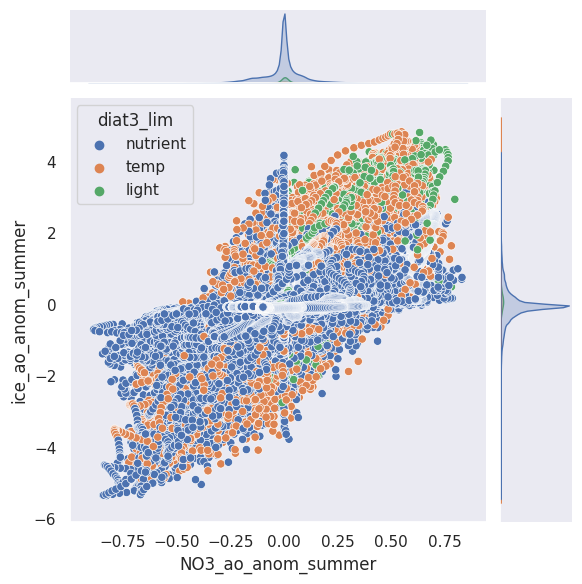

In [32]:
sns.jointplot(data=df_diat3, x="NO3_ao_anom_summer", y="ice_ao_anom_summer", hue="diat3_lim")

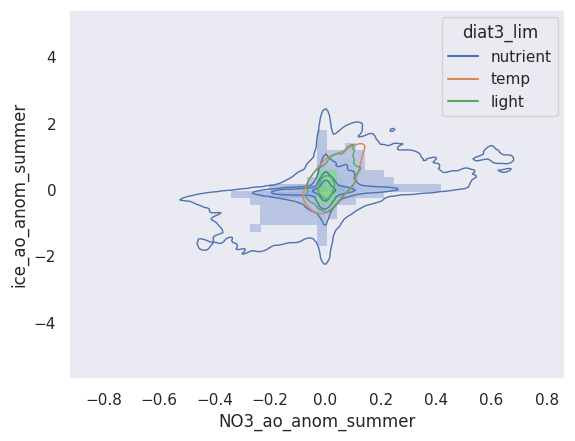

In [33]:
sns.histplot(data=df_diat3,
    x="NO3_ao_anom_summer",
    y="ice_ao_anom_summer",
    hue="diat3_lim", bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(data=df_diat3,
    x="NO3_ao_anom_summer",
    y="ice_ao_anom_summer",
    hue="diat3_lim", levels=5, color="w", linewidths=1)

In [ ]:
path_to_regrid = '/glade/u/home/gabyn/scratch/SPECTRA/growth_lim'
ds_mp1_index= xr.open_mfdataset(f"{path_to_regrid}/regrid_mp1_lim_index.nc",concat_dim='time', combine='nested') 
ds_mp1_value= xr.open_mfdataset(f"{path_to_regrid}/regrid_mp1_lim_value.nc",concat_dim='time', combine='nested')